In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

# setting plt to inline
%matplotlib inline

# updating cpi if flagged out of date
# cpi.update()

In [2]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query functions
def fetcha(q):
    return cur.execute(q).fetchall()
def fetcho(q):
    return cur.execute(q).fetchone()

In [39]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [40]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [41]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [42]:
# creating initial dataframe by joining the four tables and printing first row
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
df = pd.DataFrame(fetcha(q))
df.columns = [i[0] for i in cur.description]   

In [43]:
# # dropping extraneous columns
# df = df.drop(['idx', 'rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'directors',\
#              'authors', 'actors', 'original_release_date', 'streaming_release_date',\
#              'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating',\
#              'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count',\
#              'id', 'movie'], axis=1)
# df.head(1)

In [44]:
df.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [99]:
df.actors.isna().sum()

14

In [100]:
df['actors'] = df['actors'].fillna('NaN')

In [45]:
# change date string to datetime object 
df.release_date = pd.to_datetime(df.release_date)
df['year'] = df['release_date'].apply(lambda x: x.year)
df['month'] = df['release_date'].apply(lambda x: x.month)

In [46]:
#cleaning numerical strings and converting to floats
df['worldwide_gross'] = df['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['domestic_gross'] = df['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['production_budget'] = df['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [47]:
df['international_gross'] = df['worldwide_gross'].sub(df['domestic_gross'])

In [48]:
df['domestic_net'] = df['domestic_gross'].sub(df['production_budget'])
df['worldwide_net'] = df['worldwide_gross'].sub(df['production_budget'])
df['international_net'] = df['international_gross'].sub(df['production_budget'])

In [49]:
df['domestic_roi'] = df['domestic_net'].divide(df['production_budget'])
df['worldwide_roi'] = df['worldwide_net'].divide(df['production_budget'])
df['international_roi'] = df['international_net'].divide(df['production_budget'])

In [50]:
#adding adjust net profit columns
df['adj_dom_gross'] = df.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
df['adj_ww_gross'] = df.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
df['adj_i_gross'] = df.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
df['adj_prod_budg'] = df.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   idx                               4776 non-null   int64         
 1   rotten_tomatoes_link              4776 non-null   object        
 2   movie_title                       4776 non-null   object        
 3   movie_info                        4741 non-null   object        
 4   critics_consensus                 4134 non-null   object        
 5   content_rating                    4776 non-null   object        
 6   genres                            4776 non-null   object        
 7   directors                         4724 non-null   object        
 8   authors                           4657 non-null   object        
 9   actors                            4762 non-null   object        
 10  original_release_date             4712 non-null 

In [51]:
#adding net profit columns
df['adj_dom_net'] = df['adj_dom_gross'].sub(df['adj_prod_budg'])
df['adj_ww_net'] = df['adj_ww_gross'].sub(df['adj_prod_budg'])
df['adj_i_net'] = df['adj_i_gross'].sub(df['adj_prod_budg'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   idx                               4776 non-null   int64         
 1   rotten_tomatoes_link              4776 non-null   object        
 2   movie_title                       4776 non-null   object        
 3   movie_info                        4741 non-null   object        
 4   critics_consensus                 4134 non-null   object        
 5   content_rating                    4776 non-null   object        
 6   genres                            4776 non-null   object        
 7   directors                         4724 non-null   object        
 8   authors                           4657 non-null   object        
 9   actors                            4762 non-null   object        
 10  original_release_date             4712 non-null 

In [52]:
#adding return on investment columns and checking results
df['adj_dom_roi'] = df['adj_dom_net'].divide(df['adj_prod_budg'])
df['adj_ww_roi'] = df['adj_ww_net'].divide(df['adj_prod_budg'])
df['adj_i_roi'] = df['adj_i_net'].divide(df['adj_prod_budg'])
df.head(1)

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07,-0.065597,1.347904,0.413501


In [53]:
df.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [54]:
df = df.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
df.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

## Top 100 Films by Worldwide Gross

In [55]:
title_gross = df[['title', 'production_budget', 'worldwide_gross', 'worldwide_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top100_gross_films

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
1019,Avatar,425000000.0,2.776345e+09,2.351345e+09,5.532577,"Action & Adventure, Comedy, Mystery & Suspense...",2009,12
367,Titanic,200000000.0,2.208208e+09,2.008208e+09,10.041042,"Action & Adventure, Classics, Drama, Romance",1997,12
1021,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,5.827114,"Action & Adventure, Science Fiction & Fantasy",2018,4
2531,Jurassic World,215000000.0,1.648855e+09,1.433855e+09,6.669092,"Action & Adventure, Mystery & Suspense, Scienc...",2015,6
2017,Furious 7,190000000.0,1.518723e+09,1.328723e+09,6.993278,"Action & Adventure, Mystery & Suspense",2015,4
...,...,...,...,...,...,...,...,...
2437,Interstellar,165000000.0,6.663794e+08,5.013794e+08,3.038663,"Action & Adventure, Science Fiction & Fantasy",2014,11
2608,Kung Fu Panda 2,150000000.0,6.648375e+08,5.148375e+08,3.432250,"Action & Adventure, Animation, Comedy, Kids & ...",2011,5
2541,Justice League,300000000.0,6.559452e+08,3.559452e+08,1.186484,"Action & Adventure, Drama, Science Fiction & F...",2017,11
4222,The Martian,108000000.0,6.552714e+08,5.472714e+08,5.067328,Science Fiction & Fantasy,2015,10


In [68]:
title_adj_gross = df[['title', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_adj_titles = title_adj_gross.drop_duplicates(subset = ['title'])
top100_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top100_adj_gross_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
1054,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8
367,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,10.041042,"Action & Adventure, Classics, Drama, Romance",1997,12
1019,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,5.532577,"Action & Adventure, Comedy, Mystery & Suspense...",2009,12
357,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,123.277880,"Animation, Classics, Kids & Family, Science Fi...",1937,12
1834,The Exorcist,6.909649e+07,2.465676e+09,2.396580e+09,34.684540,"Classics, Horror",1973,12
...,...,...,...,...,...,...,...,...
4532,Up,2.085420e+08,8.716619e+08,6.631199e+08,3.179791,"Action & Adventure, Animation, Comedy, Kids & ...",2009,5
990,Armageddon,2.195827e+08,8.698612e+08,6.502785e+08,2.961429,"Action & Adventure, Mystery & Suspense, Scienc...",1998,7
297,Venom,1.181019e+08,8.690962e+08,7.509943e+08,6.358867,"Cult Movies, Horror, Mystery & Suspense",2018,10
4716,Wonder Woman,1.564481e+08,8.564315e+08,6.999835e+08,4.474223,"Action & Adventure, Animation, Drama, Kids & F...",2017,6


In [69]:
top100_gross_films.describe()

,production_budget,worldwide_gross,worldwide_net,worldwide_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.685750e+08,9.576570e+08,7.890820e+08,5.846388,2011.340000,7.250000
std,7.397127e+07,3.273300e+08,3.019174e+08,3.688244,6.067333,2.903759
min,3.500000e+07,6.522201e+08,3.559452e+08,1.186484,1993.000000,2.000000
25%,1.100000e+08,7.578371e+08,6.014434e+08,3.236404,2009.000000,5.000000
50%,1.725000e+08,8.794230e+08,7.003720e+08,4.513429,2013.000000,6.000000
75%,2.000000e+08,1.040525e+09,8.783895e+08,7.029846,2016.000000,11.000000
max,4.250000e+08,2.776345e+09,2.351345e+09,18.927371,2019.000000,12.000000


In [70]:
top100_adj_gross_films.describe()

,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.687481e+08,1.277631e+09,1.108883e+09,16.019202,2001.810000,7.580000
std,9.581017e+07,5.732113e+08,5.769721e+08,39.681137,17.395399,3.012365
min,4.493093e+06,8.547247e+08,6.252047e+08,1.546673,1937.000000,2.000000
25%,8.805160e+07,9.490569e+08,8.062123e+08,4.006988,1994.000000,5.000000
50%,1.792323e+08,1.115988e+09,9.634766e+08,5.697061,2008.500000,7.000000
75%,2.201631e+08,1.304167e+09,1.156453e+09,11.970308,2015.000000,11.000000
max,5.064591e+08,4.203440e+09,4.189983e+09,311.354312,2019.000000,12.000000


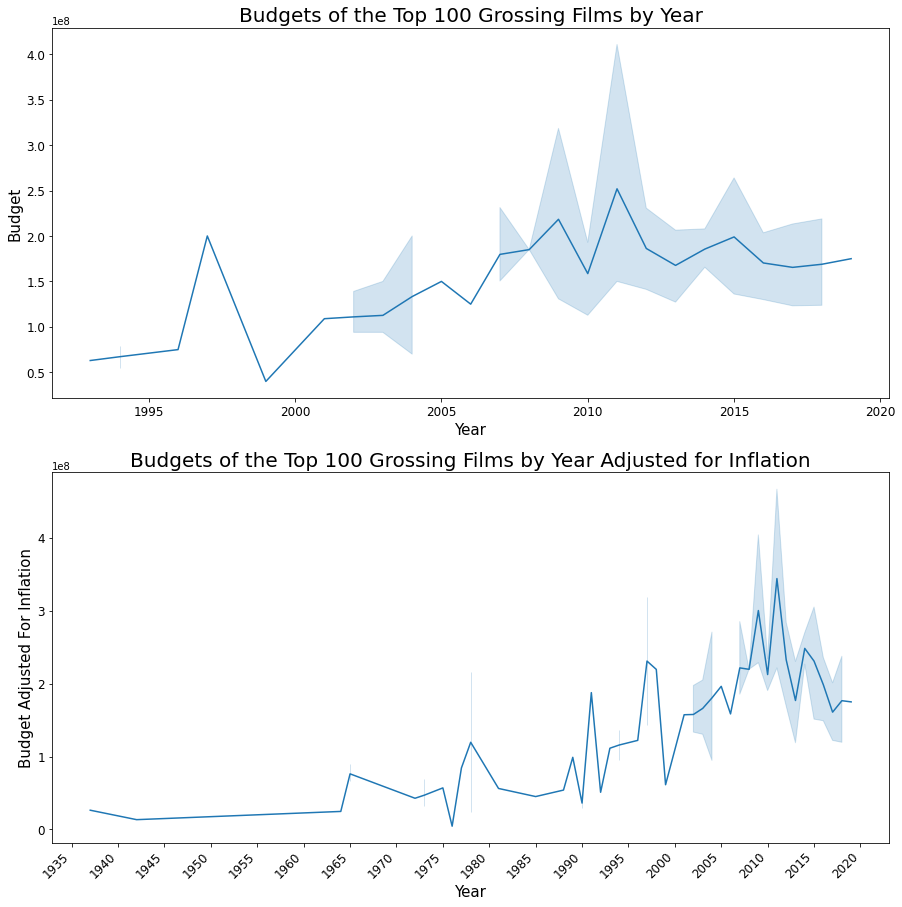

In [71]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ax=ax1)
sns.lineplot(x='year', y='adj_prod_budg', data=top100_adj_gross_films, ax=ax2)
# adjusting xticks
plt.xticks(rotation=45, ha='right')
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())

# label for x-axis 
ax1.set_xlabel( "Year", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Budget", size = 15 ) 
ax2.set_ylabel( "Budget Adjusted For Inflation", size = 15 ) 
# title for plot 
ax1.set_title( "Budgets of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Budgets of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 ) 
plt.show()

In [72]:
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_count_by_year.head(1)

,year,count
0,2017,11


In [73]:
t100_adj_count_by_year = pd.DataFrame(top100_adj_gross_films.year.value_counts()).reset_index()
t100_adj_count_by_year = t100_adj_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_adj_count_by_year.head(1)

,year,count
0,2017,7


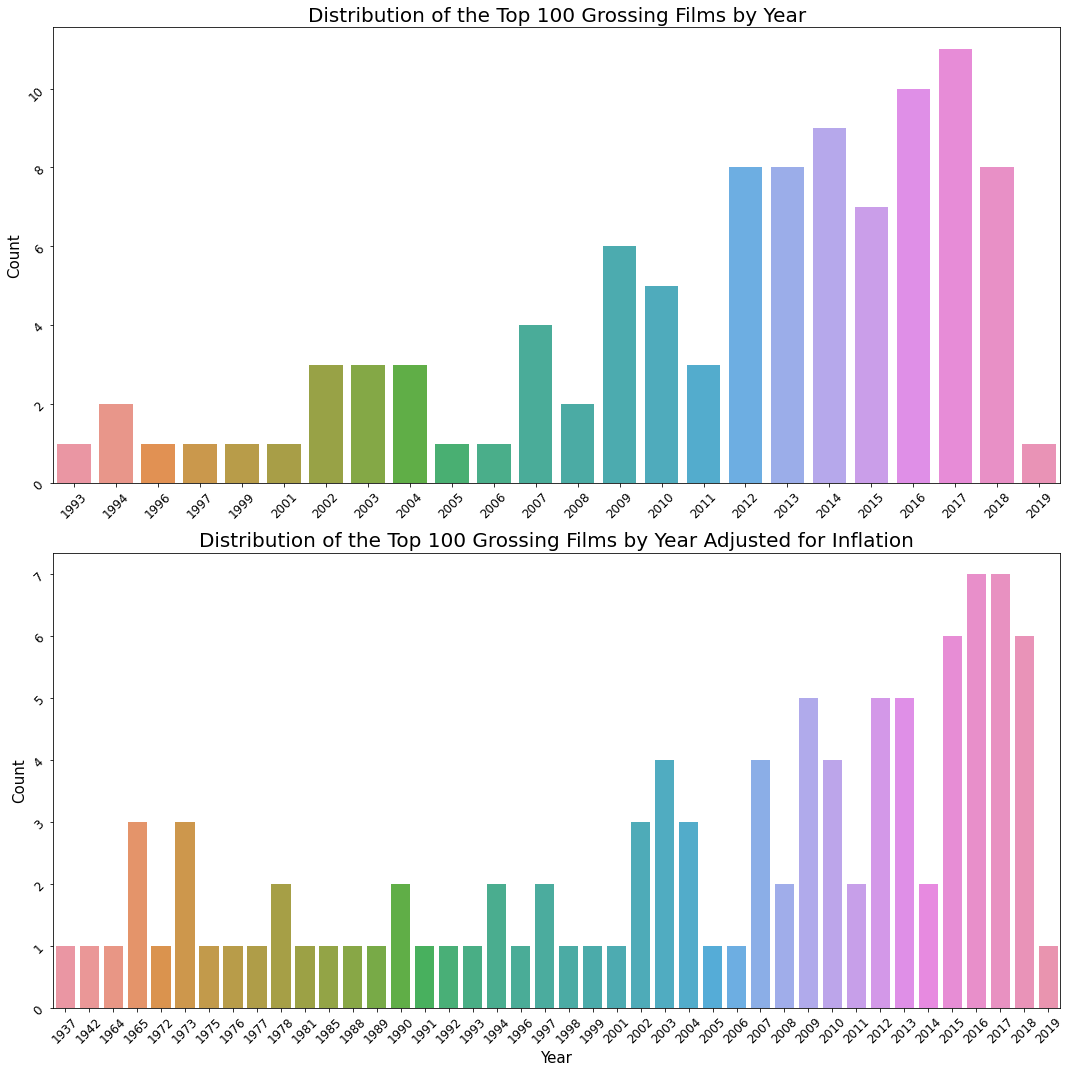

In [75]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='year', y= 'count', data=t100_count_by_year, ax = ax1)
sns.barplot(x='year', y= 'count', data=t100_adj_count_by_year, ax = ax2)
# adjusting xticks
for ax in fig.axes:
    ax.tick_params(labelrotation=45)
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
# label for x-axis 
ax1.set_xlabel( "", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Count", size = 15 ) 
ax2.set_ylabel( "Count", size = 15 ) 
# title for plot 
ax1.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Distribution of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 )
plt.tight_layout()
# render
plt.show()

In [76]:
t100_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False)
t100_gross_by_roi.head()

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
198,It,35000000.0,6.974580e+08,6.624580e+08,18.927371,"Classics, Comedy, Drama, Romance",2017,9
3711,The Sixth Sense,40000000.0,6.728063e+08,6.328063e+08,15.820157,Mystery & Suspense,1999,8
2529,Jurassic Park,63000000.0,1.038813e+09,9.758126e+08,15.489089,"Action & Adventure, Mystery & Suspense, Scienc...",1993,6
1226,Bohemian Rhapsody,55000000.0,8.949853e+08,8.399853e+08,15.272461,Drama,2018,11
2929,Minions,74000000.0,1.160336e+09,1.086336e+09,14.680219,"Animation, Comedy, Kids & Family",2015,7


In [77]:
t100_adj_gross_by_roi = top100_adj_gross_films.sort_values(by='adj_ww_roi', ascending=False)
t100_adj_gross_by_roi.head()

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
1054,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8
270,Rocky,4.493093e+06,1.010946e+09,1.006453e+09,224.000000,"Drama, Sports & Fitness",1976,11
357,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,123.277880,"Animation, Classics, Kids & Family, Science Fi...",1937,12
2114,Grease,2.352672e+07,1.519474e+09,1.495947e+09,63.585030,"Comedy, Musical & Performing Arts, Romance",1978,6
2090,Goldfinger,2.474100e+07,1.030050e+09,1.005309e+09,40.633333,"Action & Adventure, Classics, Mystery & Suspense",1964,12


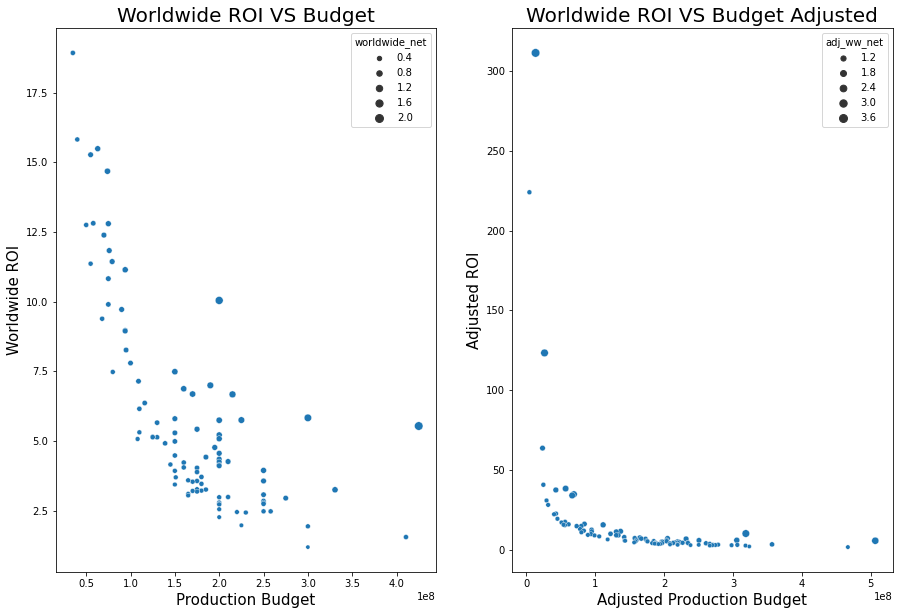

In [78]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(15,10))

sns.scatterplot(x='production_budget', y='worldwide_roi', data=top100_gross_films, size='worldwide_net', ax=ax1)

sns.scatterplot(x='adj_prod_budg', y='adj_ww_roi', data=top100_adj_gross_films, size='adj_ww_net', ax=ax2)

#label for x-axis 
ax1.set_xlabel( "Production Budget" , fontsize=15 )
ax2.set_xlabel("Adjusted Production Budget", fontsize=15)
#label for y-axis 
ax1.set_ylabel( "Worldwide ROI", fontsize=15)
ax2.set_ylabel("Adjusted ROI", fontsize=15)
# setting title
ax1.set_title("Worldwide ROI VS Budget", fontsize=20)
ax2.set_title("Worldwide ROI VS Budget Adjusted", fontsize=20)
plt.show()

In [79]:
title_net = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'year']]
unique_titles = title_net.groupby('title').first().reset_index()
top100_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_net_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,year
352,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942
2795,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,1937
3920,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,1997
321,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,2009
3241,The Exorcist,6.909649e+07,2.465676e+09,2.396580e+09,1973
...,...,...,...,...,...
3958,Transformers: Revenge of the Fallen,2.502504e+08,9.968542e+08,7.466038e+08,2009
769,Crocodile Dundee,2.052720e+07,7.655796e+08,7.450524e+08,1986
420,Beverly Hills Cop,3.690910e+07,7.782898e+08,7.413807e+08,1984
1648,Jaws 2,7.842239e+07,8.191234e+08,7.407010e+08,1978


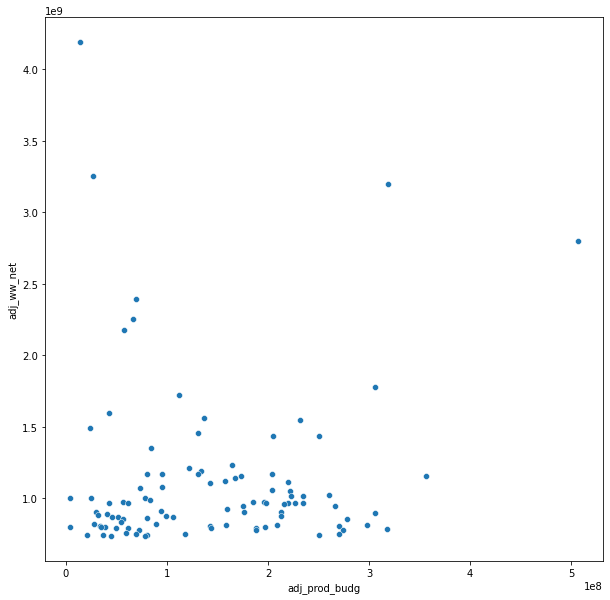

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=top100_net_films, x="adj_prod_budg", y="adj_ww_net")
plt.show()

In [81]:
title_roi = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_roi', 'year']]
unique_titles = title_roi.groupby('title').first().reset_index()
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top20_roi_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_roi,year
1909,Mad Max,6.205267e+05,3.094877e+08,497.750000,1980
2303,Paranormal Activity,5.362509e+05,2.314018e+08,430.517853,2009
3294,The Gallows,1.078644e+05,4.493251e+07,415.564740,2015
3090,The Blair Witch Project,9.207335e+05,3.810302e+08,412.833333,1999
2936,Super Size Me,8.797091e+04,3.009121e+07,341.058585,2004
352,Bambi,1.345728e+07,4.203440e+09,311.354312,1942
996,El Mariachi,1.238477e+04,3.612686e+06,290.704000,1993
2557,Rocky,4.493093e+06,1.010946e+09,224.000000,1976
3129,The Brothers McMullen,8.387697e+04,1.749087e+07,207.530120,1995
3797,The Texas Chainsaw Massacre,7.260037e+05,1.377978e+08,188.803136,1974


In [89]:
a_g = df[['title', 'actors', 'genres']]
a_g

,title,actors,genres
0,Percy Jackson & the Olympians: The Lightning T...,"Logan Lerman, Brandon T. Jackson, Alexandra Da...","Action & Adventure, Comedy, Drama, Science Fic..."
1,Please Give,"Catherine Keener, Amanda Peet, Oliver Platt, R...",Comedy
2,"10,000 B.C.","Steven Strait, Camilla Belle, Cliff Curtis, Jo...","Action & Adventure, Classics, Drama"
3,3:10 to Yuma,"Glenn Ford, Van Heflin, Felicia Farr, Leora Da...","Classics, Drama, Western"
4,Dark Water,"Hitomi Kuroki, Rio Kanno, Shigemitsu Ogi, Mire...","Art House & International, Horror, Mystery & S..."
...,...,...,...
4771,Zoolander,"Ben Stiller, Owen Wilson, Will Ferrell, Christ...","Comedy, Special Interest"
4772,Zoolander 2,"Ben Stiller, Owen Wilson, Will Ferrell, Penelo...",Comedy
4773,Zoom,"Tim Allen, Courteney Cox, Chevy Chase, Spencer...","Action & Adventure, Comedy, Kids & Family"
4774,Zootopia,"J.K. Simmons, Kristen Bell, Octavia Spencer, A...","Action & Adventure, Animation, Comedy"


In [90]:
df[df.title == 'Titanic']

,idx,rotten_tomatoes_link,title,movie_info,critics_consensus,rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
367,1017,m/1056130-titanic,Titanic,"Stuck in an unloving marriage, rich socialite ...",None,NR,"Action & Adventure, Classics, Drama, Romance",Jean Negulesco,"Charles Brackett, Walter Reisch, Richard L. Breen","Clifton Webb, Barbara Stanwyck, Robert Wagner,...",...,1.050287e+09,3.517408e+09,2.467121e+09,3.185757e+08,7.317110e+08,3.198832e+09,2.148545e+09,2.29682,10.041042,6.744222
4407,16297,m/titanic,Titanic,"James Cameron's ""Titanic"" is an epic, action-p...",A mostly unqualified triumph for James Cameron...,PG-13,"Drama, Romance",James Cameron,James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",...,1.050287e+09,3.517408e+09,2.467121e+09,3.185757e+08,7.317110e+08,3.198832e+09,2.148545e+09,2.29682,10.041042,6.744222


In [104]:
leo = df[df['actors'].str.contains('Leonardo DiCaprio')]

,idx,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,top,fresh,rotten,idx,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
count,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,20.000000,...,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000
mean,8346.250000,142.300000,67.400000,213.550000,73.300000,2.144431e+06,45.350000,149.000000,64.650000,1078.550000,...,1.585318e+08,4.274838e+08,2.689520e+08,1.076135e+08,5.091838e+07,3.198703e+08,1.613385e+08,0.288371,1.852034,0.563662
std,5966.636334,24.640788,20.924425,104.916746,14.682965,7.937421e+06,18.550855,91.139569,46.357052,1131.904658,...,2.243400e+08,7.647719e+08,5.424412e+08,7.204977e+07,1.689379e+08,7.061465e+08,4.847564e+08,0.881289,2.366918,1.806340
min,152.000000,98.000000,20.000000,41.000000,44.000000,2.169800e+04,9.000000,13.000000,5.000000,42.000000,...,1.622442e+07,1.622442e+07,0.000000e+00,1.946178e+07,-5.405076e+07,-2.255878e+07,-7.423258e+07,-0.489970,-0.443335,-1.000000
25%,3219.000000,126.000000,53.250000,173.500000,62.750000,1.242420e+05,44.250000,90.500000,27.500000,357.500000,...,4.568392e+07,9.323170e+07,0.000000e+00,5.361952e+07,-2.346439e+07,3.943205e+07,-2.367138e+07,-0.282355,0.692250,-1.000000
50%,7597.000000,140.000000,70.500000,220.500000,73.500000,2.135900e+05,53.500000,143.000000,57.000000,498.500000,...,1.193776e+08,2.387853e+08,1.438531e+08,1.017696e+08,-3.082044e+05,1.118432e+08,1.391367e+07,-0.000653,0.891082,0.156384
75%,15071.000000,158.250000,86.250000,285.000000,85.250000,4.641185e+05,57.000000,201.250000,88.000000,1658.500000,...,1.611860e+08,3.959002e+08,2.446117e+08,1.397897e+08,5.438497e+07,2.725079e+08,1.278696e+08,0.607037,2.817519,1.254186
max,17211.000000,195.000000,91.000000,397.000000,94.000000,3.579764e+07,65.000000,311.000000,155.000000,3999.000000,...,1.050287e+09,3.517408e+09,2.467121e+09,3.185757e+08,7.317110e+08,3.198832e+09,2.148545e+09,2.790457,10.041042,6.744222


In [82]:
split_list = []
for genre in df.genres:
    split_list += genre.split(',')

raw_genres = list(set(split_list))
raw_genres

['Action & Adventure',
 ' Musical & Performing Arts',
 ' Gay & Lesbian',
 'Western',
 'Art House & International',
 'Musical & Performing Arts',
 'Classics',
 ' Romance',
 'Kids & Family',
 ' Sports & Fitness',
 ' Documentary',
 ' Animation',
 'Mystery & Suspense',
 'Comedy',
 'Cult Movies',
 ' Anime & Manga',
 'Romance',
 ' Western',
 ' Art House & International',
 ' Classics',
 ' Horror',
 ' Faith & Spirituality',
 'Science Fiction & Fantasy',
 ' Drama',
 'Animation',
 ' Mystery & Suspense',
 ' Kids & Family',
 'Drama',
 'Documentary',
 ' Cult Movies',
 ' Science Fiction & Fantasy',
 ' Television',
 'Horror',
 ' Special Interest',
 ' Comedy']

In [83]:
split_list = []
for genre in df.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))
genres

['romance',
 'sports & fitness',
 'comedy',
 'television',
 'animation',
 'musical & performing arts',
 'classics',
 'kids & family',
 'special interest',
 'anime & manga',
 'art house & international',
 'drama',
 'faith & spirituality',
 'mystery & suspense',
 'western',
 'science fiction & fantasy',
 'action & adventure',
 'cult movies',
 'gay & lesbian',
 'horror',
 'documentary']

In [84]:
len(genres)

21

In [85]:
action = df[(df['genres'] == 'Action & Adventure')]
unique_titles = action.groupby('title').first().reset_index()
top100_action = unique_titles.sort_values(by='adj_ww_net', ascending=False)
top100_action

,title,idx,rotten_tomatoes_link,movie_info,critics_consensus,rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
60,The Avengers,1197,m/1083461-avengers,A charismatic evil genius named Sir August de ...,"A TV spinoff that lacks enough energy to spin,...",PG-13,Action & Adventure,Jeremiah S. Chechik,Don MacPherson,"Ralph Fiennes, Uma Thurman, Sean Connery, Eile...",...,6.940329e+08,1.690249e+09,9.962157e+08,2.505415e+08,4.434914e+08,1.439707e+09,7.456742e+08,1.770131,5.746382,2.976250
48,Raiders of the Lost Ark,12247,m/raiders_of_the_lost_ark,"Dr. Indiana Jones, a renowned archeologist and...","Featuring bravura set pieces, sly humor, and w...",PG,Action & Adventure,Steven Spielberg,Lawrence Kasdan,"Harrison Ford, Karen Allen, Paul Freeman, Wolf...",...,6.347440e+08,1.033462e+09,3.987180e+08,5.625017e+07,5.784938e+08,9.772118e+08,3.424679e+08,10.284304,17.372604,6.088300
27,Indiana Jones and the Last Crusade,8342,m/indiana_jones_and_the_last_crusade,An art collector appeals to Jones to embark on...,"Lighter and more comedic than its predecessor,...",PG-13,Action & Adventure,Steven Spielberg,Jeffrey Boam,"Harrison Ford, Sean Connery, Alison Doody, Den...",...,4.065190e+08,9.776237e+08,5.711048e+08,9.896400e+07,3.075550e+08,8.786597e+08,4.721408e+08,3.107746,8.878579,4.770833
28,Indiana Jones and the Temple of Doom,8343,m/indiana_jones_and_the_temple_of_doom,The second of the Lucas/Spielberg Indiana Jone...,"It may be too ""dark"" for some, but Indiana Jon...",PG,Action & Adventure,Steven Spielberg,"Gloria Katz, Steven Spielberg, George Lucas, W...","Harrison Ford, Kate Capshaw, Jonathan Ke Quan,...",...,4.426145e+08,8.195794e+08,3.769649e+08,6.889698e+07,3.737176e+08,7.506825e+08,3.080679e+08,5.424295,10.895724,4.471429
26,Indiana Jones and the Kingdom of the Crystal S...,8341,m/indiana_jones_and_the_kingdom_of_the_crystal...,"It's the height of the Cold War, and famous ar...",Though the plot elements are certainly familia...,PG-13,Action & Adventure,Steven Spielberg,David Koepp,"Harrison Ford, Shia LaBeouf, Cate Blanchett, K...",...,3.765350e+08,9.340736e+08,5.575386e+08,2.196743e+08,1.568607e+08,7.143993e+08,3.378642e+08,0.714060,3.252083,1.538023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Ironclad,8478,m/ironclad,"In the 13th century, a dedicated group of Knig...",Ironclad serves up plenty of crunchy gore to s...,R,Action & Adventure,Jonathan English,"Erick Kastel, Jonathan English, Stephen McDool","James Purefoy, Brian Cox, Derek Jacobi, Paul G...",...,0.000000e+00,6.020833e+06,6.020833e+06,2.841404e+07,-2.841404e+07,-2.239320e+07,-2.239320e+07,-1.000000,-0.788104,-0.788104
68,The Gunman,15101,m/the_gunman_2015,Eight years after fleeing the Congo following ...,With an uninspired plot and rote set pieces th...,R,Action & Adventure,Pierre Morel,"Don MacPherson, Pete Travis","Sean Penn, Idris Elba, Jasmine Trinca, Javier ...",...,1.150347e+07,2.005655e+07,8.553085e+06,4.314577e+07,-3.164230e+07,-2.308921e+07,-3.459268e+07,-0.733381,-0.535144,-0.801763
22,Harley Davidson and the Marlboro Man,7507,m/harley_davidson_and_the_marlboro_man,"In this action movie, tough biker Harley David...",None,R,Action & Adventure,Simon Wincer,"Don Michael Paul, Simon Wincer","Mickey Rourke, Don Johnson, Chelsea Field, Dan...",...,1.317427e+07,1.317427e+07,0.000000e+00,4.317262e+07,-2.999836e+07,-2.999836e+07,-4.317262e+07,-0.694847,-0.694847,-1.000000
42,Mortdecai,10602,m/mortdecai,Charismatic British aristocrat and part-time s...,"Aggressively strange and willfully unfunny, th...",R,Action & Adventure,David Koepp,"Eric Aronson, David Koepp","Johnny Depp, Gwyneth Paltrow, Ewan McGregor, O...",...,8.301390e+06,3.278661e+07,2.448522e+07,6.471865e+07,-5.641726e+07,-3.193204e+07,-4.023343e+07,-0.871731,-0.493398,-0.621667


In [ ]:
scifi.groupby('title').first().reset_index()

In [ ]:
scifi = df[(df['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles = scifi.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_scifi

In [ ]:
list(df[df['title'] == 'Mad Max'].genres)